# Soils Revealed precalculations with `Zarrs`

<a id='libraries'></a>
### Python libraries

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import dask.array as da
import zarr
import rioxarray
import gcsfs
from geocube.api.core import make_geocube
import shapely.wkb 
import json
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()
from pathlib import Path 
env_path = Path('.') / '.env'

<a id='utils'></a>
### Utils

**show_xarray**

In [4]:
def show_xarray(xds, colors=None, quantities=None):
    fig, ax = plt.subplots(figsize=(16,8.5))
    
    if colors and quantities:
        # Define the colors you want
        cmap = mpl.colors.ListedColormap(colors)
        # Define a normalization from values -> colors
        norm = mpl.colors.BoundaryNorm(quantities, len(colors))
        
        xds.plot(ax=ax, cmap=cmap, norm=norm)
    else:
        xds.plot(ax=ax)

<a id='df_from_carto'></a>
**df_from_carto**

In [ ]:
def df_from_carto(account, query):
    """
    It gets data by querying a carto table and converts it into a GeoDataFrame.
    """
    urlCarto = f"https://{account}.carto.com/api/v2/sql"
    
    sql = {"q": query}
    r = requests.get(urlCarto, params=sql)
    
    data = r.json()
    
    df = gpd.GeoDataFrame(data.get("rows"))
    if 'the_geom' in df.columns:
        # Change geometry from WKB to WKT format
        df['geometry'] = df.apply(lambda x: shapely.wkb.loads(x['the_geom'],hex=True), axis=1 )
        df.drop(columns=['the_geom'], inplace=True)
        if 'the_geom_webmercator' in df.columns:
            df.drop(columns=['the_geom_webmercator'], inplace=True)
        df.crs = {'init': 'epsg:4326'}
        df = df.to_crs({'init': 'epsg:4326'})
        
    return df

## Read `xarray.Dataset` from `Zarr` in Google cloud storage

In [5]:
%%time
# Connect to GS
project_name = 'soc-platform'
bucket_name = 'vizz-data-transfer'
root = bucket_name+'/SOC_maps/soil-data.zarr'
group = 'experimental-dataset-stock'
private_key = json.loads(os.getenv("PRIVATE_KEY"))

gc = gcsfs.GCSFileSystem(project=project_name, token=private_key)
store = gc.get_mapper(root)

# Return zarr group
xds = xr.open_zarr(store=store, group=group, consolidated=True)
xds

CPU times: user 77.7 ms, sys: 14.9 ms, total: 92.6 ms
Wall time: 412 ms


,Array,Chunk
Bytes,19.74 GB,6.43 MB
Shape,"(1, 36, 13883, 9872)","(1, 3, 868, 617)"
Count,3073 Tasks,3072 Chunks
Type,float32,numpy.ndarray


CPU times: user 5.47 s, sys: 2.38 s, total: 7.85 s
Wall time: 14.4 s


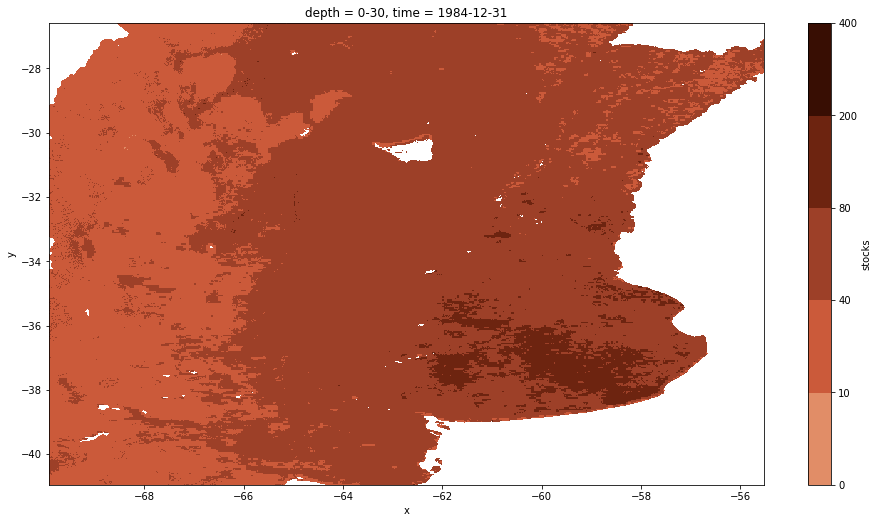

In [31]:
%%time
colors = ["#E18D67", "#CB5A3A", "#9D4028", "#6D2410", "#380E03"]
quantities = [0, 10, 40, 80, 200, 400]
show_xarray(xds['stocks'][0,2,2000:8000,2000:8000], colors, quantities)

## Read vector data
**Political boundaries**

In [ ]:
account = "wri-01"
query = "SELECT name_0, name_1, gid_0, gid_1, the_geom FROM gadm36_political_boundaries WHERE level = 1 and gid_0 = 'ARG'"

df = df_from_carto(account, query)

df['geometry'] = df['geometry'].apply(lambda x: x.simplify(0.1))

fig, ax = plt.subplots(figsize=(16,8.5))
df.plot(ax=ax)

## Zonal statistics
**Raster data**

In [ ]:
raster = xds.stocks.squeeze().drop("depth")
raster.name = "raster"
raster

**Create the data mask by rasterizing the vector data**

In [ ]:
df.reset_index(level=0, inplace=True)
df.head()

In [ ]:
%%time
out_grid = make_geocube(
    vector_data=countries,
    measurements=["index"],
    like=raster, # ensure the data are on the same grid
    fill=np.nan
)
out_grid